<img src="pic1.jpg">

# <center>A Playdate with Time Series Data: Forecasting Rossman Sales</center>

<b>This notebook explores my very first attempt playing with time series data. The data used in this work is from one of Kaggle competitions data which can be obtained here:https://www.kaggle.com/c/rossmann-store-sales. 

"Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied."


The notebook is divided into 4 sections:
1.  General Exploratory Data Analysis
2.  Stationarity, trend and seasonal attributes of the data
3.  Forecasting Model Creation using Prophet</b>

In [1]:
#Loading the libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import seaborn as sns
%matplotlib inline
import pandas as pd
from datetime import datetime
import calendar

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 50

from sklearn.metrics import mean_absolute_error, mean_squared_error 
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from fbprophet import Prophet

In [2]:
#Loading the data 
train = pd.read_csv("train.csv", parse_dates = True, low_memory = False, index_col = 'Date')
store = pd.read_csv("store.csv", low_memory = False)
test = pd.read_csv("test.csv", parse_dates = True, low_memory = False, index_col = 'Date')

# Exploratory Data Analysis

I'd like to start my exploratory activity on the data by formulating several basic questions that i wish to gain from the analysis. I found this helpful as it gives a starting point at the beginning of the analysis. The questions should be broad enough as i do not want my exploration to be limited and constraint to specific aim. Here are a few on my mind right now:
1.  What are the features that are highly likely contribute to the sales?
2.  Did promotions really help?

In [3]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [5]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


There are 8 features/columns. 2 are actually numerical i.e. Sales and Customers, the rest i would consider categorical.

No null cell in the dataframe so that's good. 

There are days when the sales amount is 0. I wonder wether it was because the store was closed. Need further investigation.

In [6]:
train[(train['Sales']==0)]['Sales'].count()

172871

In [7]:
#There are also days where the store were closed, let's take a look at this.
train[(train['Sales']==0)&(train['Open']==0)]['Sales'].count()

172817

In [8]:
float(train[(train['Sales']==0)&(train['Open']==0)]['Sales'].count())/len(train)

0.16989330609540418

About 17% of the data shows that the store were closed and thus the 0 sales. However, there are also days with 0 sales when the stores were open (we should keep these). Let's drop data only when stores were closed.

In [9]:
train = train[(train["Open"] != 0)]

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844392 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null object
SchoolHoliday    844392 non-null int64
dtypes: int64(7), object(1)
memory usage: 58.0+ MB


Sales and customer features should be related. Does more customers means more sales? Let's introduce a new feature say Sales/Customer to know more.

In [11]:
train['Sales/Customer']=train['Sales']/train['Customers']

In [12]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Sales/Customer
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000,844340.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580,9.493619
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103,2.197494
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,1.0,0.000000,0.000000,7.895563
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000,9.250000
75%,837.000000,5.000000,8360.000000,893.000000,1.0,1.000000,0.000000,10.899729
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000,64.957854


The average Sales/Customer is about 9.5. The maximum Sales, Customers, Sales/Customer made by a particular store is about 41551,7388 and $65. Let's look at the stores involved.

In [13]:
train[(train['Customers']>=7388) | (train['Sales/Customer'] >= 64.957854) | (train['Sales'] >=41551) ]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales/Customer
Date,,,,,,,,,
2015-06-22,909,1,41551,1721,1,0,0,0,24.143521
2013-09-02,897,1,16954,261,1,0,0,0,64.957854
2013-01-22,817,2,27190,7388,1,1,0,0,3.680292


Looks like more customers does not necessary means more sales. Probably some stores offers different range of products. Let's look at the store data to get more insights. But before that let's extract the year, month,day and week info from the datetime index for future analysis (incase we need it)

In [14]:
#Extracting the year,month,day and week from the index for further analysis
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['Week'] = train.index.weekofyear

In [15]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [16]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


There are 6 features with null values with 5 of the features have more than 40% null values. Let's deal these null values.

In [17]:
store[store['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [18]:
#dropping the rows with null values in column CompetitionDistance
store.drop(store[store['CompetitionDistance'].isnull()].index,inplace=True)

Handling the null values in the other 5 columns.

In [19]:
store[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']]=store[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']].fillna(value=0)

In [20]:
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].apply(lambda x:int(x))

In [21]:
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].apply(lambda x:int(x))

In [22]:
store[['PromoInterval']]=store[['PromoInterval']].fillna(value='')

In [23]:
store[['Promo2SinceWeek','Promo2SinceYear']]=store[['Promo2SinceWeek','Promo2SinceYear']].fillna(value=0)

In [24]:
store['Promo2SinceWeek']=store['Promo2SinceWeek'].apply(lambda x:int(x))

In [25]:
store['Promo2SinceYear']=store['Promo2SinceYear'].apply(lambda x:int(x))

In [26]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9,2008,0,0,0,
1,2,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9,2009,0,0,0,
4,5,a,a,29910.0,4,2015,0,0,0,


In [27]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1112 non-null int64
StoreType                    1112 non-null object
Assortment                   1112 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    1112 non-null int64
CompetitionOpenSinceYear     1112 non-null int64
Promo2                       1112 non-null int64
Promo2SinceWeek              1112 non-null int64
Promo2SinceYear              1112 non-null int64
PromoInterval                1112 non-null object
dtypes: float64(1), int64(6), object(3)
memory usage: 95.6+ KB


All set now, let's merge the train and store in one dataframe

In [28]:
df=train.copy(deep='all')
df= pd.merge(df, store, on='Store')

In [29]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales/Customer,Year,Month,Day,Week,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,9.482883,2015,7,31,31,c,a,1270.0,9,2008,0,0,0,
1,1,4,5020,546,1,1,0,1,9.194139,2015,7,30,31,c,a,1270.0,9,2008,0,0,0,
2,1,3,4782,523,1,1,0,1,9.143403,2015,7,29,31,c,a,1270.0,9,2008,0,0,0,
3,1,2,5011,560,1,1,0,1,8.948214,2015,7,28,31,c,a,1270.0,9,2008,0,0,0,
4,1,1,6102,612,1,1,0,1,9.970588,2015,7,27,31,c,a,1270.0,9,2008,0,0,0,


In [30]:
df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            842196, 842197, 842198, 842199, 842200, 842201, 842202, 842203,
            842204, 842205],
           dtype='int64', length=842206)

We lost the index from train dataframe when merging with store. We need to keep the index for further processing later on. Thus, let's add a column to store this info.

In [31]:
#Create index column to retain the datetime index information for future use
df['index']=df.apply(lambda x:datetime.strptime("{0} {1} {2} 00:00:00".format(x['Year'],x['Month'], x['Day']), "%Y %m %d %H:%M:%S"),axis=1)


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842206 entries, 0 to 842205
Data columns (total 23 columns):
Store                        842206 non-null int64
DayOfWeek                    842206 non-null int64
Sales                        842206 non-null int64
Customers                    842206 non-null int64
Open                         842206 non-null int64
Promo                        842206 non-null int64
StateHoliday                 842206 non-null object
SchoolHoliday                842206 non-null int64
Sales/Customer               842154 non-null float64
Year                         842206 non-null int64
Month                        842206 non-null int64
Day                          842206 non-null int64
Week                         842206 non-null int64
StoreType                    842206 non-null object
Assortment                   842206 non-null object
CompetitionDistance          842206 non-null float64
CompetitionOpenSinceMonth    842206 non-null int64
CompetitionOpen

Sales/Customer colums has about 50 rows with null values. Suspected those with 0 customers. Let's just drop these rows

In [33]:
df['Sales/Customer'].fillna(value=0,inplace=True)

In [34]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales/Customer,Year,Month,Day,Week,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,index
0,1,5,5263,555,1,1,0,1,9.482883,2015,7,31,31,c,a,1270.0,9,2008,0,0,0,,2015-07-31
1,1,4,5020,546,1,1,0,1,9.194139,2015,7,30,31,c,a,1270.0,9,2008,0,0,0,,2015-07-30
2,1,3,4782,523,1,1,0,1,9.143403,2015,7,29,31,c,a,1270.0,9,2008,0,0,0,,2015-07-29
3,1,2,5011,560,1,1,0,1,8.948214,2015,7,28,31,c,a,1270.0,9,2008,0,0,0,,2015-07-28
4,1,1,6102,612,1,1,0,1,9.970588,2015,7,27,31,c,a,1270.0,9,2008,0,0,0,,2015-07-27


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842206 entries, 0 to 842205
Data columns (total 23 columns):
Store                        842206 non-null int64
DayOfWeek                    842206 non-null int64
Sales                        842206 non-null int64
Customers                    842206 non-null int64
Open                         842206 non-null int64
Promo                        842206 non-null int64
StateHoliday                 842206 non-null object
SchoolHoliday                842206 non-null int64
Sales/Customer               842206 non-null float64
Year                         842206 non-null int64
Month                        842206 non-null int64
Day                          842206 non-null int64
Week                         842206 non-null int64
StoreType                    842206 non-null object
Assortment                   842206 non-null object
CompetitionDistance          842206 non-null float64
CompetitionOpenSinceMonth    842206 non-null int64
CompetitionOpen

The main dataframe is now ready for further exploratory analysis.

One quick way to see the relationship between the features is to compute correlation matrix. Let's look at seaborn heatmap plot of the correlation matrix.

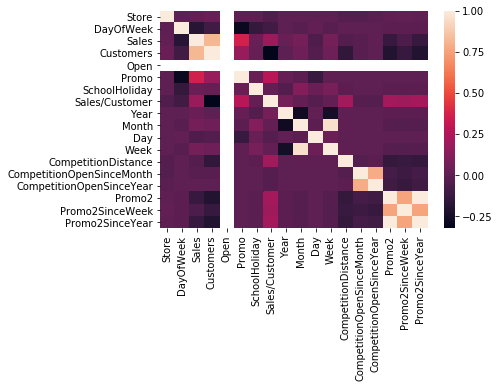

In [36]:
sns.heatmap(df.corr())

From the graph, it can be seen that 'Sales' has high correlation with no of customers and moderate correlation with promotion.

Let's analyse this further by looking at the performance by store type.

In [37]:
df.groupby('StoreType')['Sales/Customer'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,456293.0,8.843706,1.692986,0.0,7.609929,8.627699,9.896552,29.877551
b,15563.0,5.132437,1.255891,0.0,4.039105,4.986851,6.107892,9.203528
c,112978.0,8.625463,1.696192,0.0,7.416801,8.424568,9.642935,64.957854
d,257372.0,11.284580,1.992742,0.0,9.882173,11.204103,12.567681,57.614983


In [38]:
df.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,456293.0,6929.647347,3278.470505,0.0,4700.0,6290.0,8412.0,41551.0
b,15563.0,10231.407505,5157.190155,0.0,6344.0,9130.0,13183.5,38722.0
c,112978.0,6932.512755,2897.564578,0.0,4915.0,6407.0,8349.0,31448.0
d,257372.0,6825.895575,2553.669461,0.0,5056.0,6397.0,8124.0,38037.0


In [39]:
df.groupby('StoreType')['Customers'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,456293.0,795.989231,387.583295,0.0,548.0,721.0,950.0,7388.0
b,15563.0,2021.822335,911.031277,0.0,1255.0,1839.0,2750.5,5494.0
c,112978.0,815.465887,329.744701,0.0,583.0,756.0,981.0,3096.0
d,257372.0,606.256644,198.583575,0.0,464.0,577.0,716.0,2239.0


The above tables provides descriptive statistics of the 'Sales/Customer', 'Sales' and 'Customers' grouped by the type of store. 

1.  Store D has the highest 'Sales/Customer' mean although the store does not show highest sales per day .
2.  Store B shows highest sales per day and store C shows highest number of customers per day.

Let's see which store has the highest overall sales and customers.

In [40]:
df.groupby('StoreType')['Sales'].sum()

StoreType
a    3161949577
b     159231395
c     783221426
d    1756794396
Name: Sales, dtype: int64

In [41]:
df.groupby('StoreType')['Customers'].sum()

StoreType
a    363204314
b     31465621
c     92129705
d    156033485
Name: Customers, dtype: int64

Store A has the highest sales and total number of customers but store D actually has the highest sales/customers.

Notice that the data also has 'Promo' column that indicate promotional activity provided by the stores. We can make use of this information to see how's the daily sales yearly performances with and without the promotion for each store type.

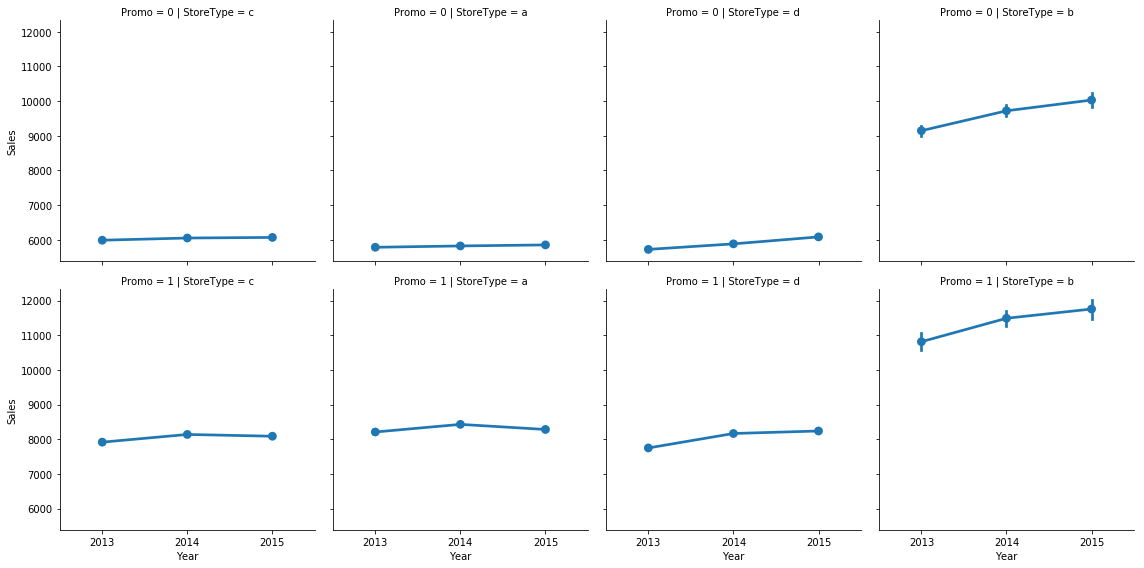

In [42]:
#It can be seen that store type b sales had the highest increase from 2013-2015
sns.factorplot(data=df, x="Year", y="Sales", col='StoreType', row='Promo')


-  In general, there were increases in sales when promotional activities were carried out. 
-  Nevertheless, the rate of increase seems to be stagnant from every year for store a,c and d. 
-  Store b shows highest yearly increase.

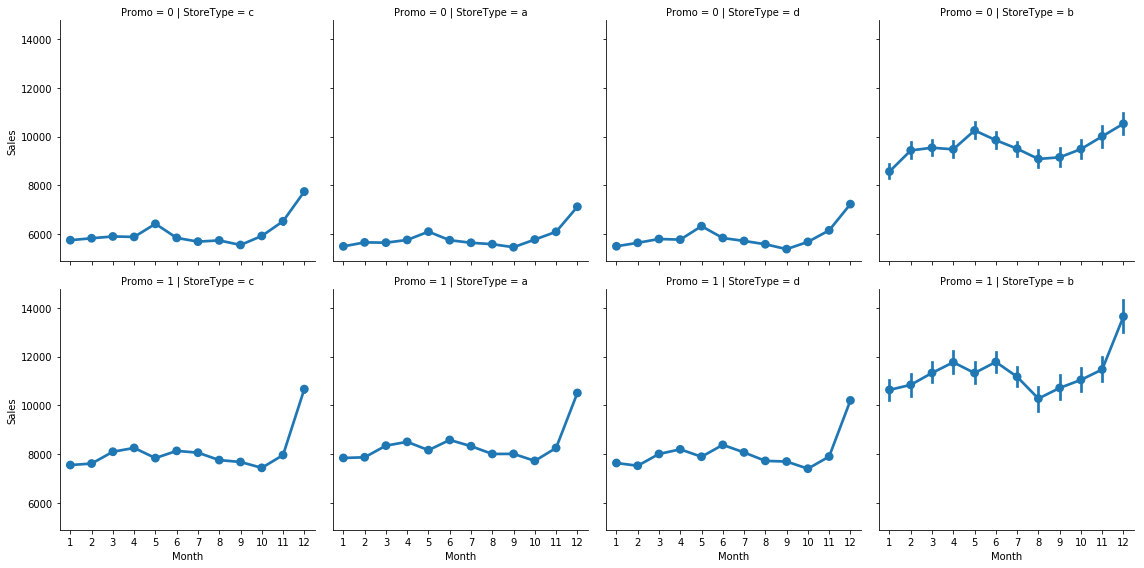

In [43]:
sns.factorplot(data=df, x="Month", y="Sales", col='StoreType', row='Promo')

As expected, December month shows the highest sales for the store with and without promotion.

Let's introduce another feature i.e. competition appearance duration and see wether it's affect the sales

In [44]:
def get_duration(Y,M,y,m):
    if y == 0:
        return 0
    else:
        return 12 * (Y - y) + (M - m)

In [45]:
df['CompetitionDuration']=df.apply(lambda x:get_duration(x['Year'],x['Month'],x['CompetitionOpenSinceYear'],x['CompetitionOpenSinceMonth']),axis=1)

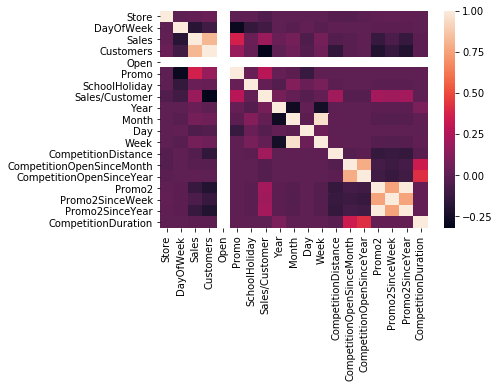

In [46]:
sns.heatmap(df.corr())

It seems the competitors appearances does not really correlates with sales performances. 

# Stationarity, trend and seasonalilty attributes

The following section will investigate the time seris attributes of the sales data. We ned to identify whether they are stationary or non-stationary data, their trend and their seasonality. Here is the plan:

1.  For each store type, find the store that has the most data. We want as much data as we can for forecasting.
2.  Perform stationarity test.
3.  Perform data decomposition to see the trend and seasonality attributes.
4.  ACF and PACF plots of the data.

In [47]:
#Setting the data frame index with the datetime index
df.set_index('index',inplace=True)

In [48]:
print(df[df['StoreType']=='a'].groupby('Store')['Store'].count().sort_values(ascending=False)[:1])
print(df[df['StoreType']=='b'].groupby('Store')['Store'].count().sort_values(ascending=False)[:1])
print(df[df['StoreType']=='c'].groupby('Store')['Store'].count().sort_values(ascending=False)[:1])
print(df[df['StoreType']=='d'].groupby('Store')['Store'].count().sort_values(ascending=False)[:2])

Store
530    906
Name: Store, dtype: int64
Store
1097    942
Name: Store, dtype: int64
Store
398    784
Name: Store, dtype: int64
Store
578    901
299    882
Name: Store, dtype: int64


In [49]:
dfA=df[df['Store']==530]
dfB=df[df['Store']==1097]
dfC=df[df['Store']==398]
dfD=df[df['Store']==299]

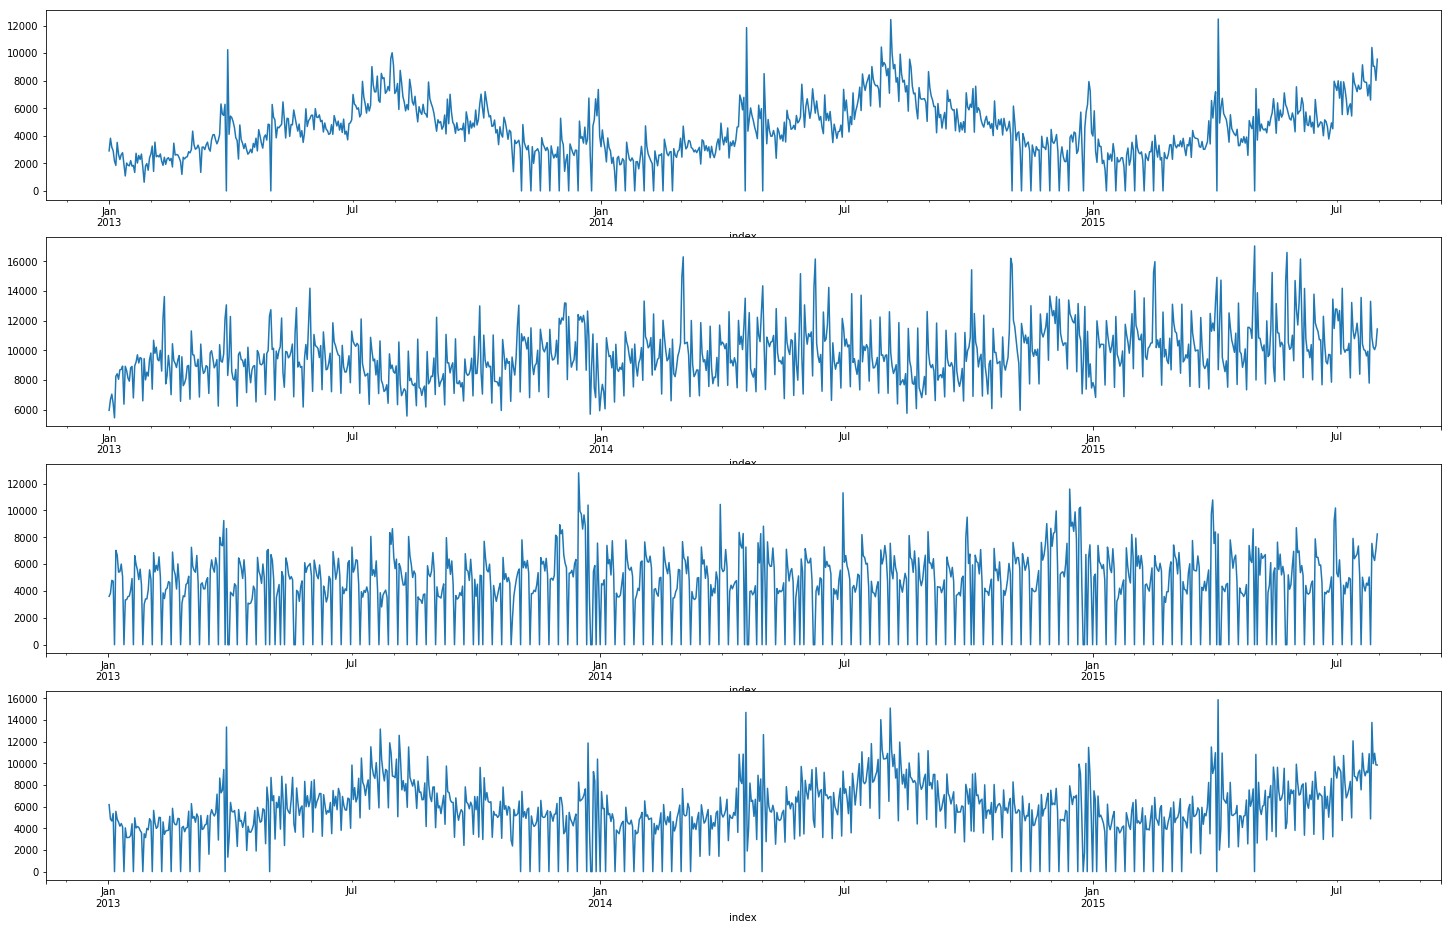

In [50]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (25, 16))
dfA.resample('D')['Sales'].sum().plot(ax = ax1)
dfB.resample('D')['Sales'].sum().plot(ax = ax2)
dfC.resample('D')['Sales'].sum().plot(ax = ax3)
dfD.resample('D')['Sales'].sum().plot(ax = ax4)

-  It can be observed from the plots that the first and last plot shows clear seasonality. The other two plots are rather vague.
-  We will check the stationarity of each data using the Dicker-Fuller test, followed by decomposition of the data and ACF & PACF plots.

In [51]:
#but first let's look at a function that will provide stationarity test
def adf_test(data):
    print ('Results of Dickey-Fuller Test:')
    result = adfuller(data, autolag='AIC')
    print ('p-values ='+str(result[1]))

In [52]:
#p <0.05 =stationary
adf_test(dfA.resample('D')['Sales'].sum())
# not stationary

Results of Dickey-Fuller Test:
p-values =0.13059480436088905


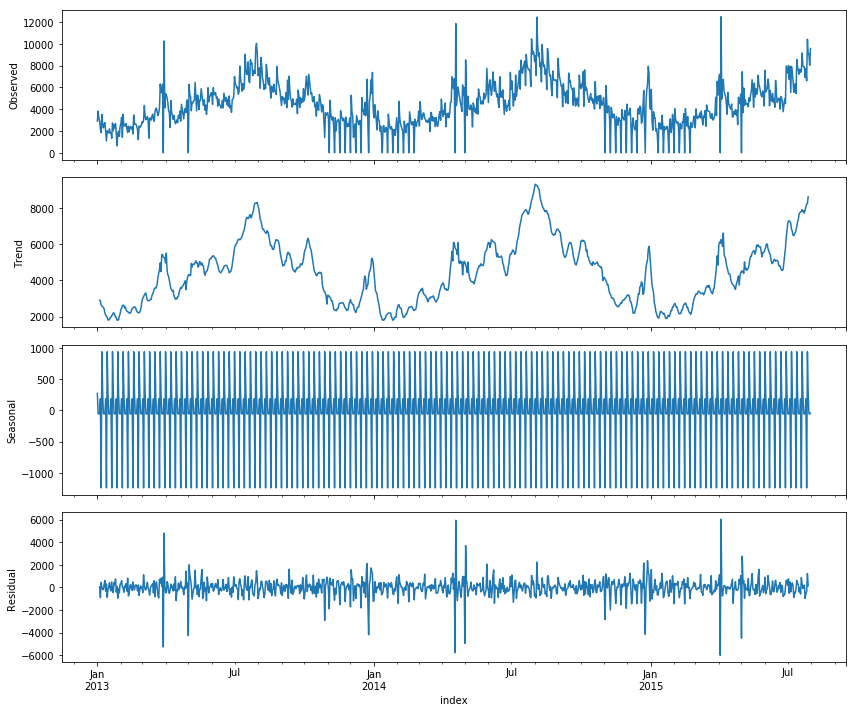

In [53]:
rcParams['figure.figsize'] = 12, 10
dfA_dec = seasonal_decompose(dfA.resample('D')['Sales'].sum(), model = 'additive')
dfAplot=dfA_dec.plot()


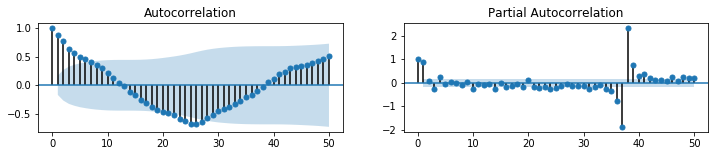

In [54]:
plt.figure(figsize = (12, 2))
plt.subplot(121);
acfplot=plot_acf(dfA.resample('W')['Sales'].sum(), lags = 50, ax = plt.gca())
plt.subplot(122); 
pacfplot=plot_pacf(dfA.resample('W')['Sales'].sum(), lags = 50, ax = plt.gca())


Store type A sales data:
- The data is non-stationary, highly seasonal with some obvious cyclic trend.
-  Plot of the ACF and PACF shows that there are high correlations within the data.


In [55]:
#p <0.05 =stationary
adf_test(dfB.resample('D')['Sales'].sum())
# stationary

Results of Dickey-Fuller Test:
p-values =0.0046406833994309315


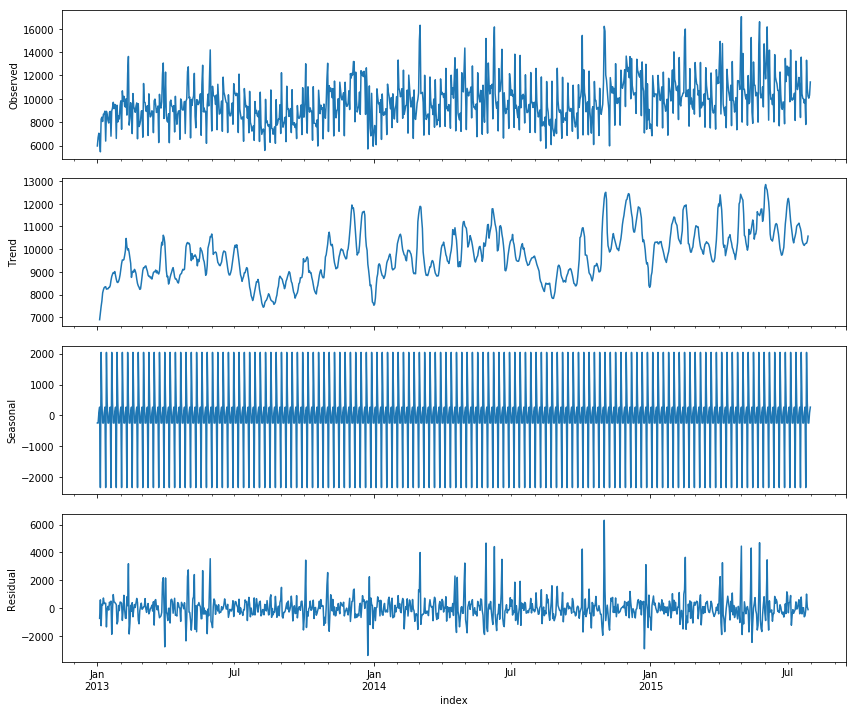

In [56]:
rcParams['figure.figsize'] = 12, 10
dfB_dec = seasonal_decompose(dfB.resample('D')['Sales'].sum(), model = 'additive')
dfBplot=dfB_dec.plot()

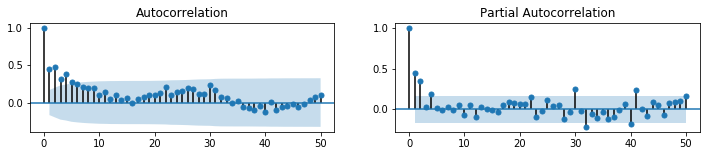

In [57]:
plt.figure(figsize = (12, 2))
plt.subplot(121); acfplot=plot_acf(dfB.resample('W')['Sales'].sum(), lags = 50, ax = plt.gca())
plt.subplot(122); pacfplot=plot_pacf(dfB.resample('W')['Sales'].sum(), lags = 50, ax = plt.gca())


Store type B sales data:

-  The data is stationary with seasonality but no trend. 
-  There are some autocrellation in the data but not as high as the previous data.

In [58]:
#p <0.05 =stationary
adf_test(dfC.resample('D')['Sales'].sum())
# stationary

Results of Dickey-Fuller Test:
p-values =4.2731621477656624e-05


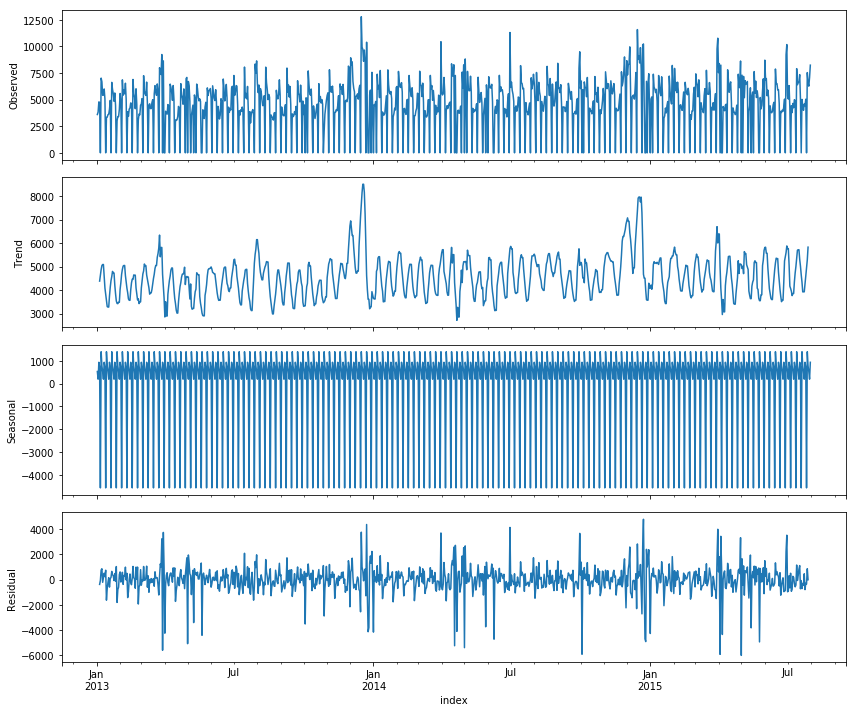

In [59]:
#rcParams['figure.figsize'] = 12, 10
dfC_dec = seasonal_decompose(dfC.resample('D')['Sales'].sum(), model = 'additive')
dfCplot=dfC_dec.plot()

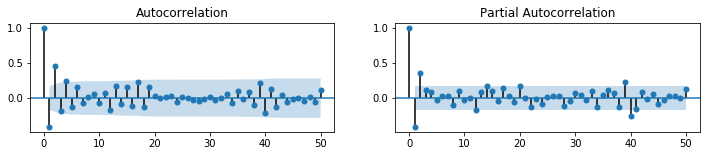

In [60]:
plt.figure(figsize = (12, 2))
plt.subplot(121); acfplot=plot_acf(dfC.resample('W')['Sales'].sum(), lags = 50, ax = plt.gca())
plt.subplot(122); pacfplot=plot_pacf(dfC.resample('W')['Sales'].sum(), lags = 50, ax = plt.gca())


Store type C sales data:

-  It is a stationary data, no trend and some seasonality (not very clear).
-  The ACF and PACF also shows some autocorrelation in the data.

In [61]:
#p <0.05 =stationary
adf_test(dfD.resample('D')['Sales'].sum())
# non-stationary

Results of Dickey-Fuller Test:
p-values =0.12504331669765822


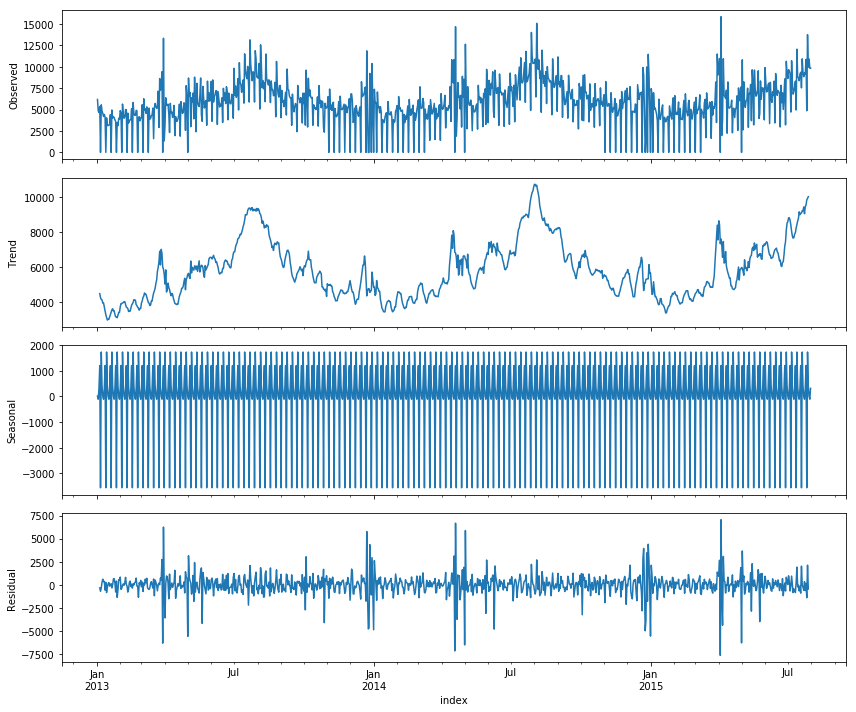

In [62]:
#rcParams['figure.figsize'] = 12, 10
dfD_dec = seasonal_decompose(dfD.resample('D')['Sales'].sum(), model = 'additive')
dfDplot=dfD_dec.plot()

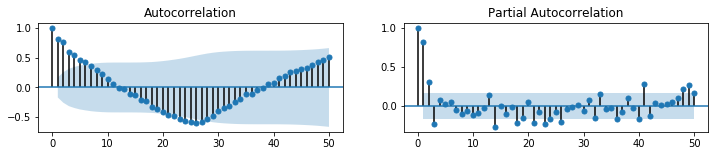

In [63]:
plt.figure(figsize = (12, 2))
plt.subplot(121); acfplot=plot_acf(dfD.resample('W')['Sales'].sum(), lags = 50, ax = plt.gca())
plt.subplot(122); pacfplot=plot_pacf(dfD.resample('W')['Sales'].sum(), lags = 50, ax = plt.gca())


Store type D sales data:

-  Non-stationary data with seasonality and cyclic trend (simillar with the first data).
-  Also shows high autocorrelation, it can be seen from the ACF and PACF plots.

# Forecasting Model Creation

We will develop two forecasting model i.e. using the Holt's Winter model approach and Prophet open source library developed by facebook for time series analysis. 

The Holt's Winter, a.k.a the triple exponential smoothing is an extensions of the exponential smoothing approach that takes into account the seasonality behaviour as well as the trend in data. Prophet on the other hand, is an additive model that also considers trend, seasonality but can also model external factors i.e. holidays. 

We will not carry out the cross-validation as normally carried to properly assessed model's performance, instead we will just compare the RMSE & MAE of the model using the fitted forecast value.

For this section we will use the store number 530, from store type 'a' for further forecasting analysis.

In [64]:
#The holt-winter model
model=ExponentialSmoothing(dfA_dec.observed, seasonal_periods=365, trend='add', seasonal='add')
model_fit = model.fit()

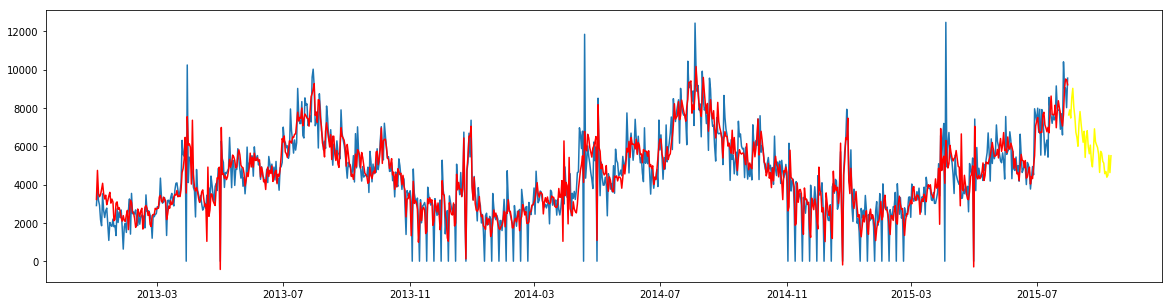

In [65]:
plt.figure(figsize = (20, 5))
plt.plot(dfA_dec.observed)
plt.plot(model_fit.fittedvalues,color='red')
plt.plot(model_fit.forecast(42),color='yellow')

In [66]:
print(mean_absolute_error(dfA_dec.observed, model_fit.fittedvalues))
print(sqrt(mean_squared_error(dfA_dec.observed, model_fit.fittedvalues)))

660.1832559342014
945.6375768885015


From the above plot, it can be seen that the fitted values fairly fit into the original data. The model can also follow the yearly seasonal trend posed by the data.

The forecast values i.e. shown as yellow lines, also follow the seasonal trend shown from the previous sales trend.

The model also provide fairly good RMSE and MAE scores i.e. 954 and 670.

In [67]:
#Creating dataframe for Prophet model input. Renaming 'sales' as 'y' and the index and 'ds' column.
dfA_p=pd.DataFrame(dfA_dec.observed)

In [68]:
dfA_p['ds']=dfA_p.index
dfA_p['y']=dfA_p['Sales']

In [69]:
dfA_p.drop(['Sales'],axis=1,inplace=True)

In [70]:
#m = Prophet(yearly_seasonality = True,seasonality_prior_scale=0.1)
model=Prophet(yearly_seasonality = True, weekly_seasonality=True)
model.fit(dfA_p)
future = model.make_future_dataframe(periods=42)
forecast = model.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


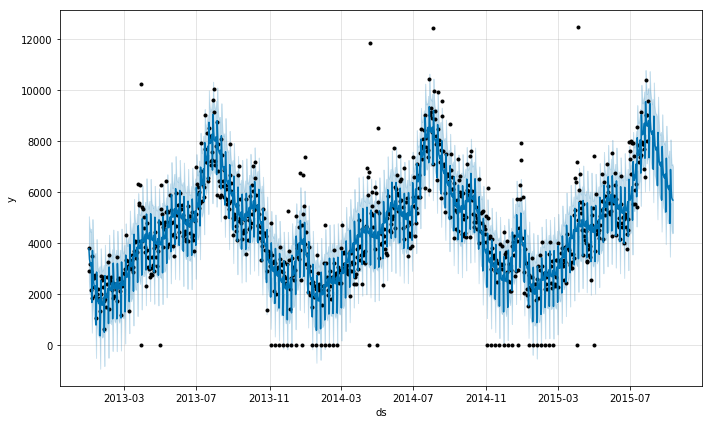

In [71]:
mplot=model.plot(forecast)

In [72]:
print(mean_absolute_error(dfA_p['y'], forecast['yhat'][:942]))
print(sqrt(mean_squared_error(dfA_p['y'], forecast['yhat'][:942])))

689.7886733916675
1006.165344010564


Let's add holiday factor into the model and see how's the model perform.

In [73]:
state_hol=df[df['StateHoliday']!='0'].index
school_hol=df[df['SchoolHoliday']==1].index

In [74]:
states = pd.DataFrame({'holiday': 'state_holiday','ds': pd.to_datetime(state_hol)})
schools = pd.DataFrame({'holiday': 'school_holiday','ds': pd.to_datetime(school_hol)})

In [75]:
holiday = pd.concat((states, schools))      
holiday.head()

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday


In [76]:
model2=Prophet(holidays=holiday,yearly_seasonality = True, weekly_seasonality=True)
model2.fit(dfA_p)
future2 = model2.make_future_dataframe(periods=42)
forecast2 = model2.predict(future2)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


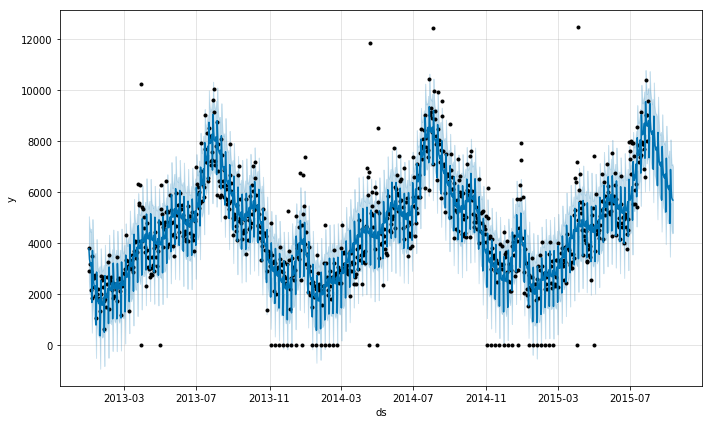

In [77]:
mplot=model2.plot(forecast)

In [78]:
print(mean_absolute_error(dfA_p['y'], forecast2['yhat'][:942]))
print(sqrt(mean_squared_error(dfA_p['y'], forecast2['yhat'][:942])))

681.4019088573727
959.3632321127026


# Conclusions

-  This notebook provides an exploratory analysis of Rossmann store sales from 2013 until July 2015.
-  The analysis provides some insights on some of the factors that affect the sales performance, stores that shows 
   increases in yearly sales' performances, store that has highest sales/customer ratio and etc.
-  We also found out that the store with highest sales/customer ratio is not the ones iwth the highes sales.
-  Four different stores were further analysed in this notebook in which we checked for their stationarity, trend and    sesonality.
-  The ACF and PACF plot were also derived from the data to further understand their behaviour.
-  We have compared the fitted values plots from two models i.e. the Hotls-Winter model and an additive model from 
   Prophet API.
-  Finally the MAE and RMSE scores from these models were also compared. Their performance is pretty comparable.